# Project

In [1]:
import os
import yaml
import pytimeloop.timeloopfe.v4 as tl
from pytimeloop.timeloopfe.common.nodes import DictNode
from pytimeloop.timeloopfe.v4.art import Art
from pytimeloop.timeloopfe.v4.ert import Ert
import shutil

In [2]:
def run_timeloop_mapper(architecture, problem, constraints, mapper, config: dict = None):
    if os.path.exists("./output_dir"):
        os.system("rm -r ./output_dir")

    if config:
        spec = tl.Specification.from_yaml_files(architecture, problem, constraints, mapper, jinja_parse_data=config)
    else:
        spec = tl.Specification.from_yaml_files(architecture, problem, constraints, mapper)

    result = tl.accelergy_app(spec, output_dir="./output_dir")
    shutil.copy("output_dir/ART.yaml", "output_dir/timeloop-mapper.ART.yaml")
    shutil.copy("output_dir/ERT.yaml", "output_dir/timeloop-mapper.ERT.yaml")

    spec.ERT = Ert(**DictNode.from_yaml_files("output_dir/ERT.yaml")["ERT"])
    spec.ART = Art(**DictNode.from_yaml_files("output_dir/ART.yaml")["ART"])
    
    spec.ERT['tables'][0]['actions'][1]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][2]['energy'] = 0.0
    spec.ERT['tables'][0]['actions'][3]['energy'] = 0.0

    return tl.call_mapper(spec, output_dir="./output_dir")

In [126]:
def run_data_parallel(problem, num_gpus, pe_array_size):
    result = run_timeloop_mapper(
        architecture='designs/system/arch.yaml',
        problem=problem,
        constraints='designs/system/constraints_dp.yaml',
        mapper='designs/_include/mapper.yaml',
        config={'gpu_meshX': num_gpus, 'pe_meshX': pe_array_size, 'pe_meshY': pe_array_size}
    )
    return result
    
    # out_dir = f"./outputs/{num_gpus}_{pe_array_size}_{problem[-6]}_dp"
    # if os.path.exists(out_dir):
    #     shutil.rmtree(out_dir)
    # shutil.copytree("./output_dir", out_dir)

In [125]:
def run_tensor_parallel(problem, num_gpus, pe_array_size):
    result = run_timeloop_mapper(
        architecture='designs/system/arch.yaml',
        problem=problem,
        constraints='designs/system/constraints_tp.yaml',
        mapper='designs/_include/mapper.yaml',
        config={'gpu_meshX': num_gpus, 'pe_meshX': pe_array_size, 'pe_meshY': pe_array_size}
    )
    return result
    
    # out_dir = f"./outputs/{num_gpus}_{pe_array_size}_{problem[-6]}_tp"
    # if os.path.exists(out_dir):
    #     shutil.rmtree(out_dir)
    # shutil.copytree("./output_dir", out_dir)

In [92]:
LAYERS = [
    'layer_shapes/alexnet/0.yaml',
    # 'layer_shapes/alexnet/1.yaml',
    # 'layer_shapes/alexnet/2.yaml',
    # 'layer_shapes/alexnet/3.yaml',
    # 'layer_shapes/alexnet/4.yaml',
    # 'layer_shapes/alexnet/5.yaml',
    # 'layer_shapes/alexnet/6.yaml',
    # 'layer_shapes/alexnet/7.yaml'
]

NUM_GPUS = [16,]

### Data-Parallel

In [132]:
for num_gpus in NUM_GPUS:
    print("Number of GPUs: ", num_gpus)

    total_energy = 0
    total_cycles = 0
    
    for problem in LAYERS:
        result = run_data_parallel(problem, num_gpus, 16)

        print(problem, result.energy, result.cycles)
        print(result.per_component_energy)
        # print(result.mapping)
    
        total_energy += result.energy
        total_cycles += result.cycles

    print(total_energy, total_cycles)

Number of GPUs:  16
layer_shapes/alexnet/0.yaml 0.04088130765312 93702400
{'MAC': 0.01473001728, 'RegisterFile': 0.003756536712192, 'LocalBuffer': 0.020363225659392, 'LocalMemory': 0.002031528001536, 'SystemMemory': 0, 'inter_GPU_spatial': 0, 'inter_PE_spatial': 0}
0.04088130765312 93702400


### Tensor-Parallel

In [131]:
for num_gpus in NUM_GPUS:
    print("Number of GPUs: ", num_gpus)
    
    total_energy = 0
    total_cycles = 0
    
    for problem in LAYERS:
        run_tensor_parallel(problem, num_gpus, 16)
        
        stats = open('./output_dir/timeloop-mapper.stats.txt', 'r').read()
    
        # print(stats)
        # print(result.mapping)
    
        lines = stats.split('\n')
        energy = float([l for l in lines if 'Energy:' in l][0].split(' ', 2)[1])
        cycles = int([l for l in lines if 'Cycles:' in l][0].split(' ', 1)[1])

        parsed_processed_input = open('./output_dir/parsed-processed-input.yaml', 'r').read()
        instance = yaml.safe_load(parsed_processed_input)['problem']['instance']

        num_hops = num_gpus * (num_gpus - 1)
        tensor_size = instance['N'] * instance['M'] * instance['P'] * instance['Q']
        
        network_energy = num_hops * tensor_size * 1.3e-6 * 16
        
        total_energy += energy + network_energy
        total_cycles += cycles
        
        print(problem, energy + network_energy, cycles)
    
    print(total_energy, total_cycles)

Number of GPUs:  16
layer_shapes/alexnet/0.yaml 105846.4368 93702400
105846.4368 93702400


In [82]:
import matplotlib.pyplot as plt
import numpy as np

total_energy_dp = np.array([320536.32, 326133.50999999995, 359342.34, 421380.81, 544487.17])
total_latency_dp = np.array([1828792320, 919068672, 457198080, 228599040, 114299520])
conv_energy_dp = np.array([40836.68, 40839.65, 40845.6, 40857.5, 40881.29])
conv_latency_dp = np.array([1499238400, 749619200, 374809600, 187404800, 93702400])
fc_energy_dp = np.array([3084.45, 3691.62, 5761.71, 10067.64, 18576.15])
fc_latency_dp = np.array([1638400, 819200, 409600, 204800, 102400])

total_energy_tp = np.array([320536.32, 320649.1754816, 332405.39288959996, 379613.1234848, 519341.167792])
total_latency_tp = np.array([1828792320, 914396160, 457984512, 228803840, 119561472])
conv_energy_tp = np.array([40836.68, 41562.58064, 44560.69384, 56742.22792, 105846.4368])
conv_latency_tp = np.array([1499238400, 749619200, 374809600, 187404800, 93702400])
fc_energy_tp = np.array([3084.45, 2947.9624000000003, 3166.6344, 3011.5972, 3752.578])
fc_latency_tp = np.array([1638400, 819200, 409600, 409600, 114688])

Text(0.5, 1.0, 'AlexNet')

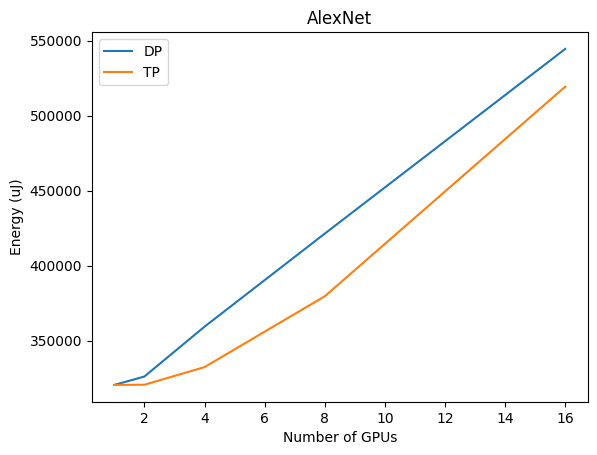

In [85]:
plt.plot(NUM_GPUS, total_energy_dp, label="DP")
plt.plot(NUM_GPUS, total_energy_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Energy (uJ)")
plt.legend()
plt.title("AlexNet")

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
# fig.suptitle('Plots')
# ax1.plot(NUM_GPUS, total_energy_dp)
# ax1.plot(NUM_GPUS, total_energy_tp)
# ax2.plot(NUM_GPUS, total_latency_dp)
# ax2.plot(NUM_GPUS, total_latency_tp)

# ax3.plot(NUM_GPUS, conv_energy_dp)
# ax3.plot(NUM_GPUS, conv_energy_tp)
# ax4.plot(NUM_GPUS, conv_latency_dp)
# ax4.plot(NUM_GPUS, conv_latency_tp)

# ax5.plot(NUM_GPUS, fc_energy_dp)
# ax5.plot(NUM_GPUS, fc_energy_tp)
# ax6.plot(NUM_GPUS, fc_latency_dp)
# ax6.plot(NUM_GPUS, fc_latency_tp)

# for ax in fig.get_axes():
#     ax.label_outer()

Text(0.5, 1.0, 'AlexNet')

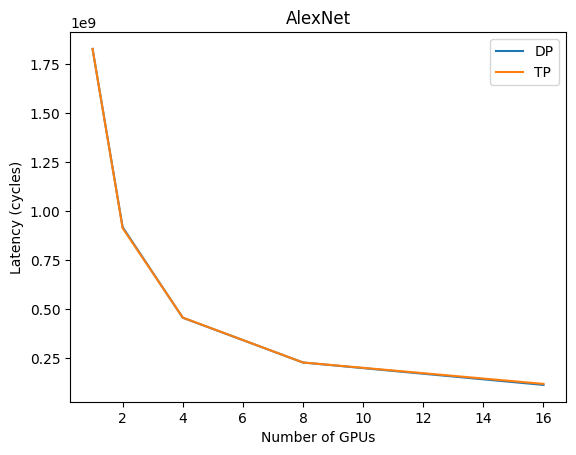

In [88]:
plt.plot(NUM_GPUS, total_latency_dp, label="DP")
plt.plot(NUM_GPUS, total_latency_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Latency (cycles)")
plt.legend()
plt.title("AlexNet")

Text(0.5, 1.0, 'CONV')

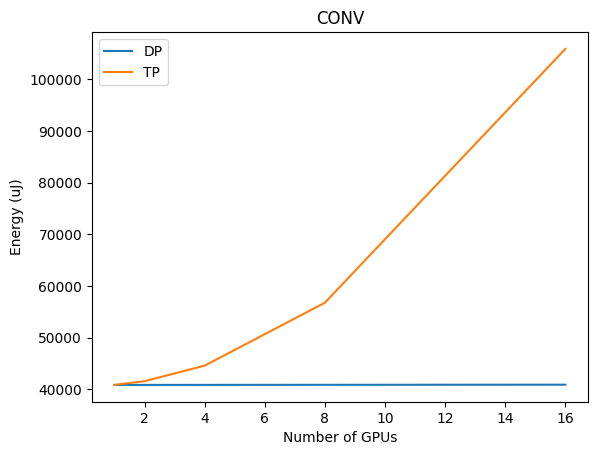

In [89]:
plt.plot(NUM_GPUS, conv_energy_dp, label="DP")
plt.plot(NUM_GPUS, conv_energy_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Energy (uJ)")
plt.legend()
plt.title("CONV")

Text(0.5, 1.0, 'FC')

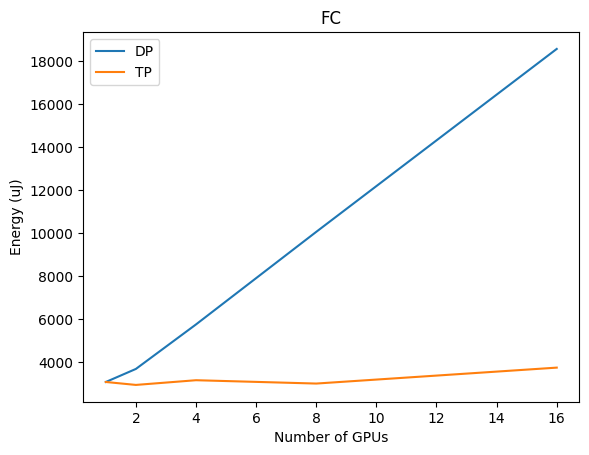

In [90]:
plt.plot(NUM_GPUS, fc_energy_dp, label="DP")
plt.plot(NUM_GPUS, fc_energy_tp, label="TP")
plt.xlabel("Number of GPUs")
plt.ylabel("Energy (uJ)")
plt.legend()
plt.title("FC")